In [156]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco/python")

from geo import closest_point_on_track, closest_distance_dom_track
from geo import cherenkov_cylinder_coordinates_v
from geo import rho_dom_relative_to_track_v
from geo import get_xyz_from_zenith_azimuth
from geo import convert_spherical_to_cartesian_direction
from geo import __c

from network import TriplePandleNet
from trafos import transform_network_outputs_v, transform_network_inputs_v

from sim_data_i3 import I3SimHandlerFtr

In [158]:
jax.devices()

[cuda(id=0), cuda(id=1)]

In [159]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/detector_geometry.csv')

In [160]:
event_data = sim_handler.get_per_dom_summary_from_index(2)

In [179]:
print(event_data)
print(event_data['charge'].max())
print(event_data['charge'].sum())

     sensor_id  charge       x       y       z     time
0       1316.0       2 -492.43 -230.16 -455.56  11065.0
1       1918.0       2 -447.74 -113.13 -486.53  10712.0
2       1919.0       2 -447.74 -113.13 -503.55  11264.0
3       1974.0       2 -324.39  -93.43 -418.99  10443.0
4       1977.0       2 -324.39  -93.43 -470.05  10075.0
..         ...     ...     ...     ...     ...      ...
97      4603.0       6 -101.06  490.22 -230.41  11911.0
98      4604.0       2 -101.06  490.22 -247.43  11931.0
99      4606.0       2 -101.06  490.22 -281.47  12079.0
100     4607.0       2 -101.06  490.22 -298.49  13468.0
101     4612.0       2 -101.06  490.22 -383.59  12314.0

[102 rows x 6 columns]
16
372


In [163]:
meta, pulses = sim_handler.get_event_data(2)
print(meta['muon_energy_at_detector'])
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

4719.856364512047


In [164]:
print(event_data)

     sensor_id  charge       x       y       z     time
0       1316.0   1.125 -492.43 -230.16 -455.56  11065.0
1       1918.0   0.375 -447.74 -113.13 -486.53  10712.0
2       1919.0   0.925 -447.74 -113.13 -503.55  11264.0
3       1974.0   0.275 -324.39  -93.43 -418.99  10443.0
4       1977.0   0.800 -324.39  -93.43 -470.05  10075.0
..         ...     ...     ...     ...     ...      ...
97      4603.0   4.100 -101.06  490.22 -230.41  11911.0
98      4604.0   1.550 -101.06  490.22 -247.43  11931.0
99      4606.0   1.425 -101.06  490.22 -281.47  12079.0
100     4607.0   1.025 -101.06  490.22 -298.49  13468.0
101     4612.0   0.775 -101.06  490.22 -383.59  12314.0

[102 rows x 6 columns]


In [165]:
def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df['x'], df['y'], df['z'], s=np.sqrt(df['charge']*100), c=df['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

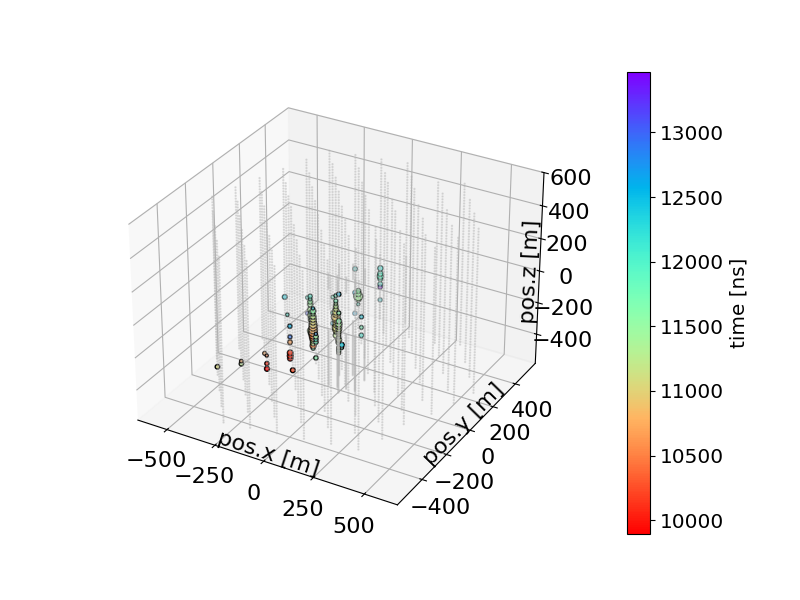

In [166]:
plot_event(event_data, geo=sim_handler.geo)

In [168]:
# convert charge to integers ("photon counts"
event_data['charge'] = np.round(event_data['charge']+0.5).astype(int)

In [169]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
source_dir = jnp.array([track_zenith, track_azimuth])

track_dir_xyz = get_xyz_from_zenith_azimuth(source_dir)
dom_positions = jnp.array(event_data[['x', 'y', 'z']].to_numpy())

In [170]:
geo_time, closest_approach_dist, closest_approach_z = \
    cherenkov_cylinder_coordinates_v(dom_positions, 
                                     track_pos, 
                                     track_dir_xyz)

closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, track_pos, track_dir_xyz)

In [171]:
print(np.sort((event_data['time'].values - (geo_time + track_time)))[:10])

[-0.37655428 -0.23947486  2.7534845   7.12941863  8.10049702  8.40697091
  9.94588794 10.5764416  11.07487338 13.60221358]


In [172]:
net = TriplePandleNet('../../data/network/')
x = jnp.column_stack([closest_approach_dist, 
                      closest_approach_rho, 
                      closest_approach_z, 
                      jnp.repeat(track_zenith, len(closest_approach_dist)), 
                      jnp.repeat(track_azimuth, len(closest_approach_dist))])

x_prime = transform_network_inputs_v(x)
y_pred = net.eval_on_batch(x_prime)
logits, a, b = transform_network_outputs_v(y_pred)

In [34]:
print(logits)

[[ 2.01649866  0.38525556  1.10741534]
 [ 1.22470523  0.29157374  1.51456117]
 [ 1.20813802  0.23800515  1.51309706]
 [ 1.38695368  0.90508503  0.90703898]
 [ 1.61591193  1.17017736  1.01290852]
 [ 1.64247562  1.29332563  1.06584503]
 [ 1.61677435  1.14184074  1.01235411]
 [ 1.22424983  0.63653111  0.84341137]
 [ 1.84934364  0.06848238  1.04149959]
 [ 1.32939268  0.79243218  0.69766448]
 [ 1.28427338  1.03388588  0.98543014]
 [ 0.84618991  0.72415638  1.29692319]
 [ 0.85015701  0.73836447  1.19336765]
 [ 0.77336191  0.67198361  1.17630466]
 [ 1.82619505  0.10713997  1.39600293]
 [ 1.59140182  0.47074024  0.78088326]
 [ 1.46634717  0.82470906  0.51753925]
 [ 1.43008337  0.91007736  0.54824824]
 [ 1.34426886  1.09692405  0.9500451 ]
 [ 1.88178632  0.05758997  1.51257286]
 [ 2.10596165 -0.29663242  1.55781684]
 [ 1.62551926  0.07547712  1.39408073]
 [ 1.35876934  1.14539697  1.16692602]
 [ 1.37544501  1.14426944  1.20336076]
 [ 1.41546755  1.13583588  1.2555867 ]
 [ 1.4854189   1.13057882

[ 1.20535844e+03  7.32192473e+02  1.33583890e+03  2.99153602e+02
  1.38700629e+02  9.18148219e+01  1.69468284e+02  4.88026189e+02
  1.74372861e+03  2.35866119e+03  2.64270831e+02  2.03542873e+01
  7.12941863e+00  2.75348450e+00  1.82990760e+03  6.13035769e+02
  1.20170514e+03  1.08651882e+03  1.18969224e+03  1.22349658e+03
  7.05223274e+02  1.09966312e+03  1.21430777e+03  4.27825348e+02
  3.35304569e+02  2.61731246e+02  1.45083259e+02  1.70324131e+02
  2.21389247e+02  4.61527077e+01  1.87334315e+02  7.32146393e+01
  9.94588794e+00  1.05764416e+01  6.33973742e+02  8.69401942e+02
  1.65191783e+01  1.24924732e+03  6.67061992e+02  2.38518253e+02
  3.84335694e+02  2.47228293e+02  1.14974871e+02  1.36822195e+02
  1.84936581e+02  1.55499533e+02  3.52876834e+02  2.85710474e+02
  3.72128048e+02  2.83970695e+02  7.35992194e+02  2.81496814e+02
  9.22542423e+02  6.57991497e+02  6.13813310e+02  2.40259922e+02
  1.76851363e+02  2.08253788e+02  9.69911855e+02  2.12532607e+02
  6.87814566e+02  2.06638

/home/storage/hans/jax_reco/python/plotting_tools.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


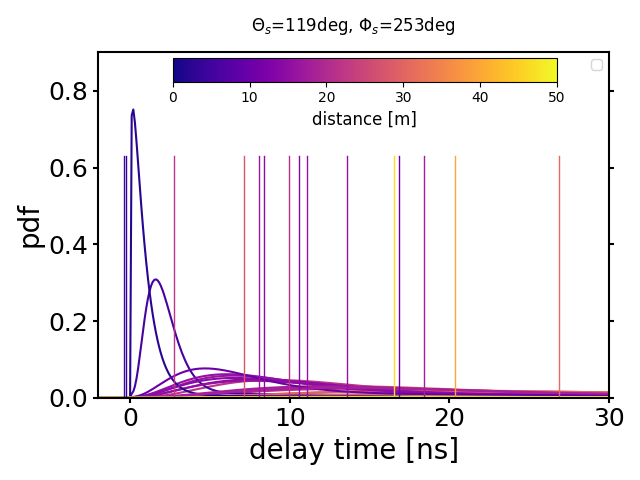

In [173]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from plotting_tools import adjust_plot_1d

n = logits.shape[0]
cmap = plt.cm.plasma
c_map = plt.cm.ScalarMappable(norm=Normalize(vmin=0, vmax=50), cmap=cmap)

dists = np.array(closest_approach_dist)
cols = [c_map.to_rgba(dist) for dist in dists]

# create a batch of mixture distributions
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

# vectorized plotting
xvals = np.linspace(-10, 1000, 10000)
xvals = xvals.reshape(10000, 1) # allow broadcasting along batch dimension
#xvals = np.repeat(xvals[np.newaxis,:], 20, axis=0).T

yvals = gm.prob(xvals)

fig, ax = plt.subplots()
ax.set_prop_cycle(color=cols)
plt.plot(xvals, yvals)

delay_times = event_data['time'].values - (geo_time + meta['muon_time'])
print(delay_times)
for dt, col in zip(delay_times, cols):
    plt.axvline(float(dt), ymax=0.7, linewidth=1, color=col)

plot_args = {'xlim':[-2, 30],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

zenith = np.rad2deg(meta['muon_zenith'])
azimuth = np.rad2deg(meta['muon_azimuth'])
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg", pad=15)
plt.tight_layout()
cax = fig.add_axes([0.27, 0.83, 0.6, 0.05])
cb = fig.colorbar(c_map, cax=cax, orientation='horizontal')
cb.set_label('distance [m]',fontsize=12)
plt.show()

In [220]:
def resample_times(event_data, track_pos, track_dir, track_time, network, seed=0):
    """
    """
    
    dom_positions = jnp.array(event_data[['x', 'y', 'z']].to_numpy())
    charges = jnp.array(event_data['charge'].to_numpy())
    geo_time, closest_approach_dist, closest_approach_z = \
    cherenkov_cylinder_coordinates_v(dom_positions, 
                                     track_pos, 
                                     track_dir_xyz)

    closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, track_pos, track_dir)
    x = jnp.column_stack([closest_approach_dist, 
                      closest_approach_rho, 
                      closest_approach_z, 
                      jnp.repeat(track_zenith, len(closest_approach_dist)), 
                      jnp.repeat(track_azimuth, len(closest_approach_dist))])

    x_prime = transform_network_inputs_v(x)
    y_pred = network.eval_on_batch(x_prime)
    logits, av, bv = transform_network_outputs_v(y_pred)

    def _sample(logit, a, b, time_offset, charge, prng_key):
        gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logit
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
        )
        times = gm.sample(sample_shape = charge, seed = prng_key)
        return jnp.amin(times+time_offset)

    first_times = []
    prng_key = jax.random.PRNGKey(seed)
    for i in range(len(event_data)):
        if i%10 == 0:
            print(i)
        time_offset = geo_time[i] + track_time
        prng_key, subkey = jax.random.split(prng_key)
        first_times.append(_sample(logits[i], av[i], bv[i], time_offset, charges[i], subkey))

    return first_times    

In [223]:
first_times_mc = resample_times(event_data, track_pos, track_dir_xyz, track_time, net, seed=3)

0
10
20
30
40
50
60
70
80
90
100


102


(9500.0, 13500.0)

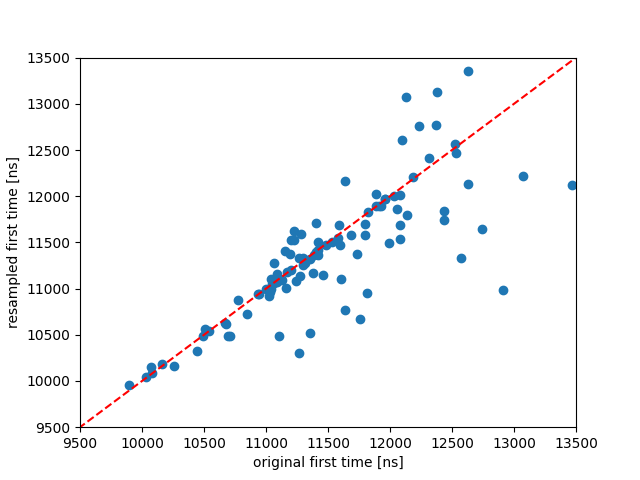

In [224]:
print(len(first_times_mc))
plt.figure()
plt.scatter(event_data['time'], first_times_mc)
plt.xlabel("original first time [ns]")
plt.ylabel("resampled first time [ns]")
plt.plot([0, 100000], [0, 100000], "r--")
plt.xlim([9500, 13500])
plt.ylim([9500, 13500])

(9500.0, 13500.0)

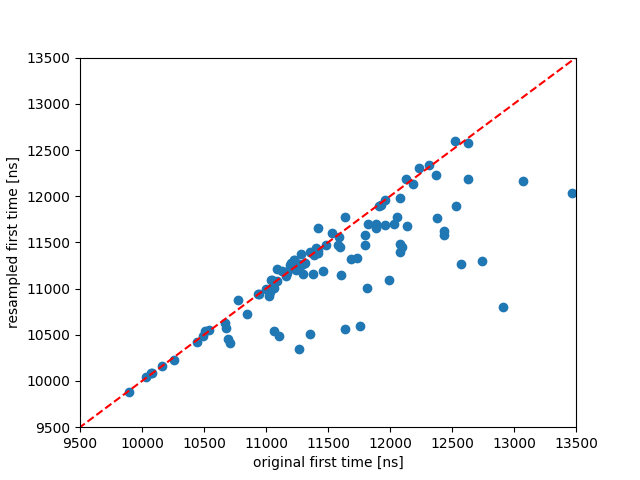

In [210]:
plt.figure()
plt.scatter(event_data['time'], first_times_mc)
plt.xlabel("original first time [ns]")
plt.ylabel("resampled first time [ns]")
plt.plot([0, 100000], [0, 100000], "r--")
plt.xlim([9500, 13500])
plt.ylim([9500, 13500])

,sensor_id,charge,x,y,z,time
0,1316.0,2.0,-492.43,-230.16,-455.56,11065.0
1,1918.0,1.0,-447.74,-113.13,-486.53,10712.0
2,1919.0,1.0,-447.74,-113.13,-503.55,11264.0
3,1974.0,1.0,-324.39,-93.43,-418.99,10443.0
4,1977.0,1.0,-324.39,-93.43,-470.05,10075.0
...,...,...,...,...,...,...
97,4603.0,5.0,-101.06,490.22,-230.41,11911.0
98,4604.0,2.0,-101.06,490.22,-247.43,11931.0
99,4606.0,2.0,-101.06,490.22,-281.47,12079.0
100,4607.0,2.0,-101.06,490.22,-298.49,13468.0


In [258]:
def resample_times_fast(event_data, track_pos, track_dir, track_time, network, prng_key):
    """
    """
    
    dom_positions = jnp.array(event_data[['x', 'y', 'z']].to_numpy())
    charges = jnp.array(event_data['charge'].to_numpy())
    geo_time, closest_approach_dist, closest_approach_z = \
    cherenkov_cylinder_coordinates_v(dom_positions, 
                                     track_pos, 
                                     track_dir_xyz)

    closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, track_pos, track_dir)
    x = jnp.column_stack([closest_approach_dist, 
                      closest_approach_rho, 
                      closest_approach_z, 
                      jnp.repeat(track_zenith, len(closest_approach_dist)), 
                      jnp.repeat(track_azimuth, len(closest_approach_dist))])

    x_prime = transform_network_inputs_v(x)
    y_pred = network.eval_on_batch(x_prime)
    logits, av, bv = transform_network_outputs_v(y_pred)

    gm = tfd.MixtureSameFamily(
              mixture_distribution=tfd.Categorical(
                  logits=logits
                  ),
              components_distribution=tfd.Gamma(
                concentration=av,    
                rate=bv,
                force_probs_to_zero_outside_support=True
                  )
            )
    
    n_tot = jnp.amax(charges)
    times = gm.sample(sample_shape = n_tot, seed = prng_key)

    n_doms = times.shape[1]
    first_times = np.zeros(n_doms)

    for i in range(n_doms):
        first_times[i] = np.amin(times[:charges[i], i])
    
    return first_times + geo_time + track_time

In [259]:
key = jax.random.PRNGKey(2)

In [264]:
key, subkey = jax.random.split(key)
first_times = resample_times_fast(event_data, track_pos, track_dir_xyz, track_time, net, subkey)

(9500.0, 13500.0)

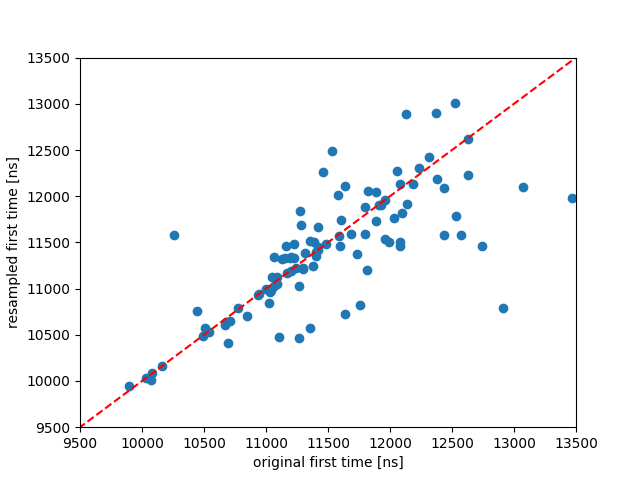

In [265]:
plt.figure()
plt.scatter(event_data['time'], first_times)
plt.xlabel("original first time [ns]")
plt.ylabel("resampled first time [ns]")
plt.plot([0, 100000], [0, 100000], "r--")
plt.xlim([9500, 13500])
plt.ylim([9500, 13500])

(102,)

In [99]:
gm = tfd.MixtureSameFamily(
              mixture_distribution=tfd.Categorical(
                  logits=logits
                  ),
              components_distribution=tfd.Gamma(
                concentration=a,    
                rate=b,
                force_probs_to_zero_outside_support=True
                  )
            )

In [102]:
mc = gm.sample(sample_shape = 100, seed = jax.random.PRNGKey(0))

In [103]:
mc.shape

(100, 102)

In [117]:
def _sample(logits, a, b, n_tot):
    gm = tfd.MixtureSameFamily(
              mixture_distribution=tfd.Categorical(
                  logits=logits
                  ),
              components_distribution=tfd.Gamma(
                concentration=a,    
                rate=b,
                force_probs_to_zero_outside_support=True
                  )
            )
    mc = gm.sample(sample_shape = n_tot, seed = jax.random.PRNGKey(0))
    return mc

In [122]:
times = _sample(logits, a, b, 1000)

In [123]:
times.shape

(1000, 102)

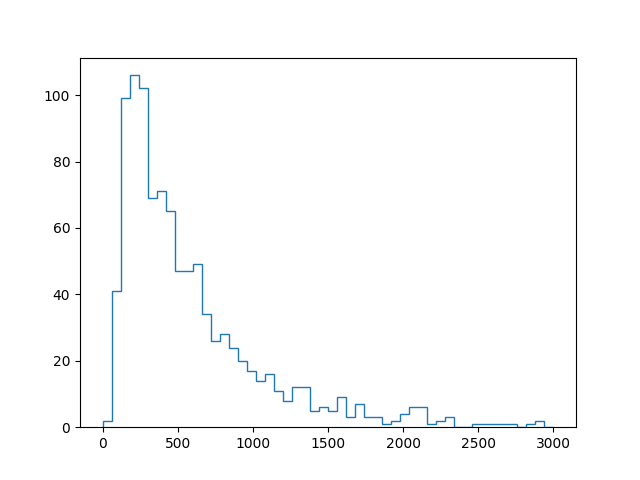

In [144]:
plt.figure()
plt.hist(times[:, 6], bins=np.linspace(0, 3000, 51), histtype='step')
plt.show()

In [140]:
np.argsort(closest_approach_dist)

Array([ 89,  71,  97,  33,  90,  72,  88,  70,  96,  98,  34,  32,  13,
        12,  73,  87,  69,  35,  31,  11,  91,  74,  95,  68,  99,  36,
        30,  75,  67, 100,  37,  29,   5,  76,  66,  28,  77,  18,  65,
        27,  10,   4,  46,  47,   6,  45,  48,  44,  78,  26,  79,  43,
        84,  92,  49,  42,  60,  59,  61,  64,  25,  50,  58,  80,   9,
        57,  41,  17,  51, 101,  24,  40,  93,   7,  56,   3,  62,  16,
        85,  55,  81,  63,  23,  15,  54,  22,  14,  53,   2,  39,   1,
        21,   8,  86,  20,  19,  82,  94,  83,   0,  52,  38],      dtype=int64)

In [113]:
times

ValueError: number of dimensions must be within [0, 32]

In [145]:
type(jax.random.PRNGKey(0))

jaxlib.xla_extension.ArrayImpl

In [152]:
event_data['charge'].max()

16.0

In [241]:
for i in zip(np.linspace(0, 10, 10), [0 for i in range(10)]):
    print(i)

(0.0, 0)
(1.1111111111111112, 0)
(2.2222222222222223, 0)
(3.3333333333333335, 0)
(4.444444444444445, 0)
(5.555555555555555, 0)
(6.666666666666667, 0)
(7.777777777777779, 0)
(8.88888888888889, 0)
(10.0, 0)
